![example](images/director_shot.jpeg)

# Microsoft Studio Analysis

**Authors:** Ricardo Chin
***


## Overview

This project uses exploratory data analysis to generate insight into the movie industry for Microsoft stakeholders to consider.

## Business Problem

Microsoft has decided to take part in the movie industry. A movie studio has been created and insight into the endeavor can greatly increase the probability of success.  Through exploration of top performing films and studios, recommendations will be created to decide on.

## Data Understanding
![imdb](./images/imdb.jpg)

[IMDB](https://www.imdb.com/) and its affiliate [Box office mojo](https://www.boxofficemojo.com/) are top leaders in online box office reporting and analysis services that track box office receipts.  We will be looking at data from a compressed file format and gathering info from a database.  The data sets contain information on movie titles, studios, domestic gross sales, movie runtimes, and other film attributes. 



In [2]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from pandasql import sqldf
from zipfile import ZipFile

%matplotlib inline
pysql = lambda q: sqldf(q, globals())

## Data Preparation

We will be looking at a csv dataset from [Box office mojo](https://www.boxofficemojo.com/) and a sql database downloaded from [Kaggle](https://www.kaggle.com) that includes resources from IMDB.

### Box office data

The Box office dataset includes movie records from the year 2010 through 2018. These records contain details of movie titles, studio, domestic gross, foreign gross, and year of release. 

In [3]:
# intaking box office mojo data
box_office = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
box_office.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [4]:
box_office['title'].describe()

count          3387
unique         3386
top       Bluebeard
freq              2
Name: title, dtype: object

In [5]:
# finding duplicate rows
df_duplicate = box_office[box_office['title'] == 'Bluebeard']
df_duplicate

,title,studio,domestic_gross,foreign_gross,year
317,Bluebeard,Strand,33500.0,5200,2010
3045,Bluebeard,WGUSA,43100.0,NaN,2017


In [6]:
# investigating studio column
box_office['studio'].describe()

count     3382
unique     257
top        IFC
freq       166
Name: studio, dtype: object

#### There are 257 unique abbreviations. Due to the large number of abbreviations, holding off on converting the abbrevistions until the relevant data is cleaned will minimize the amount of studio names to replace.

In [7]:
# checking our domestic gross values
print(box_office['domestic_gross'].dtype)
print(box_office['domestic_gross'].shape)

float64
(3387,)


### IMDB database exploration



In [8]:
# Connecting to database
conn = sqlite3.connect('zippedData/movies.sqlite')
# building sql cursor
cur = conn.cursor()
# Checking for existing tables
table_names = cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""").fetchall()
table_names

[('movies',), ('sqlite_sequence',), ('directors',)]

In [9]:
q = """
SELECT * 
FROM movies
"""
data = cur.execute(q).fetchall()
columns = [x[0] for x in cur.description]
movies_df = pd.DataFrame(data=data, columns=columns)
movies_df.info()

q = """
SELECT * 
FROM directors
"""
data = cur.execute(q).fetchall()
columns = [x[0] for x in cur.description]
directors_df = pd.DataFrame(data=data, columns=columns)
directors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4773 entries, 0 to 4772
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              4773 non-null   int64  
 1   original_title  4773 non-null   object 
 2   budget          4773 non-null   int64  
 3   popularity      4773 non-null   int64  
 4   release_date    4773 non-null   object 
 5   revenue         4773 non-null   int64  
 6   title           4773 non-null   object 
 7   vote_average    4773 non-null   float64
 8   vote_count      4773 non-null   int64  
 9   overview        4770 non-null   object 
 10  tagline         3951 non-null   object 
 11  uid             4773 non-null   int64  
 12  director_id     4773 non-null   int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 484.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2349 entries, 0 to 2348
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ---

In [10]:
q = """
WITH directors_names AS (
SELECT name, id, gender
FROM directors_df)

SELECT movies_df.revenue, movies_df.original_title, movies_df.budget, movies_df.popularity, movies_df.release_date, movies_df.vote_average,
movies_df.vote_count, directors_names.name, directors_names.gender
FROM movies_df
LEFT JOIN directors_names
ON movies_df.director_id = directors_names.id;
"""
df = pysql(q)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4773 entries, 0 to 4772
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   revenue         4773 non-null   int64  
 1   original_title  4773 non-null   object 
 2   budget          4773 non-null   int64  
 3   popularity      4773 non-null   int64  
 4   release_date    4773 non-null   object 
 5   vote_average    4773 non-null   float64
 6   vote_count      4773 non-null   int64  
 7   name            4773 non-null   object 
 8   gender          4773 non-null   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 335.7+ KB


In [11]:
sorted = df.sort_values(by='revenue', ascending=False)

In [12]:
sorted.budget.value_counts()[0]

1014

In [13]:
sorted['budget_by_mill'] = sorted['budget'].div(1000000)
sorted['rev_by_bill'] = sorted['revenue'].div(1000000000)
index_drop = sorted[sorted['budget'] == 0].index
sorted.drop(index_drop, inplace=True)
sorted.info()
#### Graph

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3759 entries, 0 to 3186
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   revenue         3759 non-null   int64  
 1   original_title  3759 non-null   object 
 2   budget          3759 non-null   int64  
 3   popularity      3759 non-null   int64  
 4   release_date    3759 non-null   object 
 5   vote_average    3759 non-null   float64
 6   vote_count      3759 non-null   int64  
 7   name            3759 non-null   object 
 8   budget_by_mill  3759 non-null   float64
 9   rev_by_bill     3759 non-null   float64
dtypes: float64(3), int64(4), object(3)
memory usage: 323.0+ KB


In [14]:
df['revenue'].describe()

count    4.773000e+03
mean     8.277710e+07
std      1.632374e+08
min      0.000000e+00
25%      0.000000e+00
50%      1.947811e+07
75%      9.361701e+07
max      2.787965e+09
Name: revenue, dtype: float64

<AxesSubplot:xlabel='budget', ylabel='revenue'>

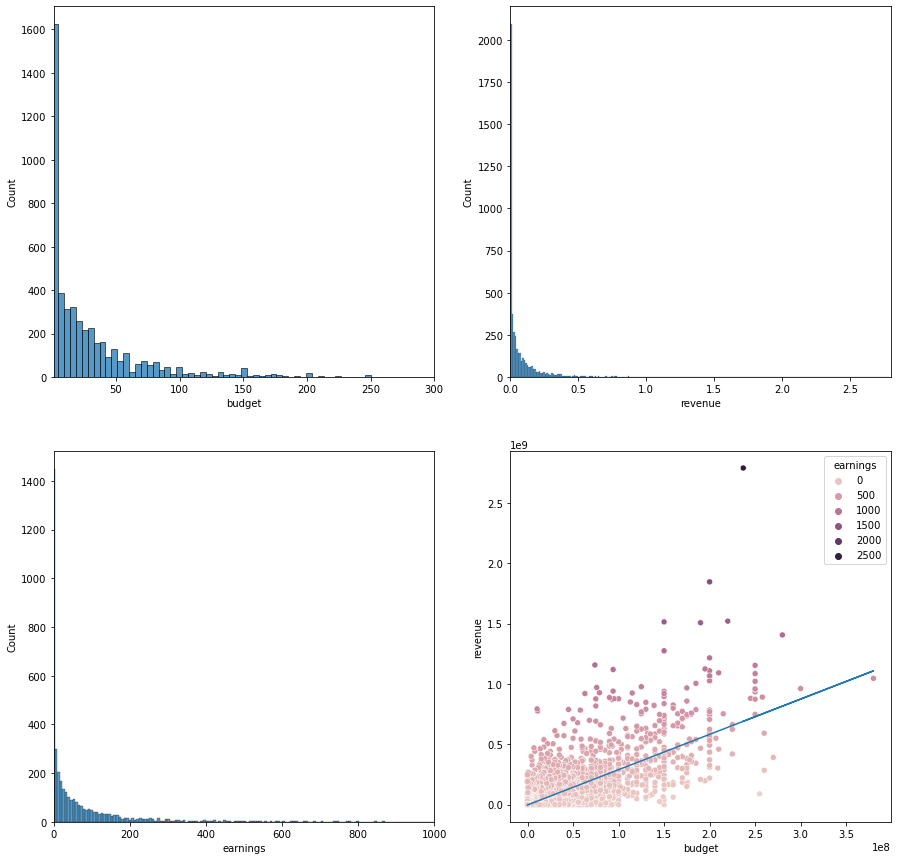

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(15,15), nrows=2, ncols=2)
ax1.set_xlim(left=1, right=300)
sns.histplot(x=(df['budget']/1000000), ax=ax1)
ax2.set_xlim(left=0, right=2.8)
sns.histplot(x=(df['revenue']/1000000000), ax=ax2)
ax3.set_xlim(0, 1000)
df['earnings'] = (df['revenue']-df['budget'])/1000000
sns.histplot(x=df['earnings'], ax=ax3)

m, b = np.polyfit(df['budget'], df['revenue'], 1)
ax4 = plt.plot(df['budget'], m*df['budget'] + b)
sns.scatterplot(x='budget', y='revenue', hue='earnings', data=df)


distplot budget, revenue, and earnings 
scatterplot(budget to revenue)

In [16]:
ds_budget = df.budget.describe().apply(lambda x: format(x, 'f'))
ds_revenue = df.revenue.describe().apply(lambda x: format(x, 'f'))
ds_earnings = df.earnings.describe().apply(lambda x: format(x, 'f'))

print(ds_budget, ds_revenue, ds_earnings)

count         4773.000000
mean      29224612.721559
std       40786792.163336
min              0.000000
25%         950000.000000
50%       15000000.000000
75%       40000000.000000
max      380000000.000000
Name: budget, dtype: object count          4773.000000
mean       82777095.058454
std       163237435.727842
min               0.000000
25%               0.000000
50%        19478106.000000
75%        93617009.000000
max      2787965087.000000
Name: revenue, dtype: object count    4773.000000
mean       53.552482
std       136.327752
min      -165.710090
25%        -0.899095
50%         2.780255
75%        55.737889
max      2550.965087
Name: earnings, dtype: object


(0.0, 60.0)

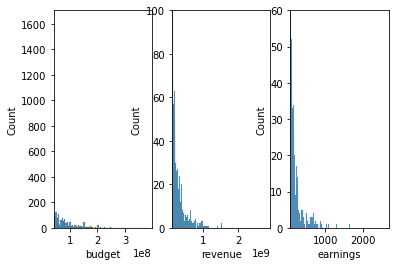

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

std_budget = df.budget.std()
sns.histplot(x=(df['budget']), ax=ax1)
ax1.set_xlim(left=std_budget)

sns.histplot(x=(df['revenue']), ax=ax2)
ax2.set_xlim(left=90000000)
ax2.set_ylim(top=100)

sns.histplot(x=(df['earnings']), ax=ax3)
ax3.set_xlim(left=55)
ax3.set_ylim(top=60)

In [18]:
index_to_drop = df[df['budget'] == 0].index
dropped_df = df.drop(index_to_drop)
dropped_df.info()
dropped_df['efficiency'] = dropped_df['revenue']/dropped_df['budget']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3759 entries, 0 to 4769
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   revenue         3759 non-null   int64  
 1   original_title  3759 non-null   object 
 2   budget          3759 non-null   int64  
 3   popularity      3759 non-null   int64  
 4   release_date    3759 non-null   object 
 5   vote_average    3759 non-null   float64
 6   vote_count      3759 non-null   int64  
 7   name            3759 non-null   object 
 8   earnings        3759 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 293.7+ KB


In [19]:
dropped_df.sort_values(by='revenue', ascending=False).head(10)

,revenue,original_title,budget,popularity,release_date,vote_average,vote_count,name,earnings,efficiency
0,2787965087,Avatar,237000000,150,2009-12-10,7.2,11800,James Cameron,2550.965087,11.763566
25,1845034188,Titanic,200000000,100,1997-11-18,7.5,7562,James Cameron,1645.034188,9.225171
16,1519557910,The Avengers,220000000,144,2012-04-25,7.4,11776,Joss Whedon,1299.557910,6.907081
28,1513528810,Jurassic World,150000000,418,2015-06-09,6.5,8662,Colin Trevorrow,1363.528810,10.090192
44,1506249360,Furious 7,190000000,102,2015-04-01,7.3,4176,James Wan,1316.249360,7.927628
7,1405403694,Avengers: Age of Ultron,280000000,134,2015-04-22,7.3,6767,Joss Whedon,1125.403694,5.019299
124,1274219009,Frozen,150000000,165,2013-11-27,7.3,5295,Chris Buck,1124.219009,8.494793
31,1215439994,Iron Man 3,200000000,77,2013-04-18,6.8,8806,Shane Black,1015.439994,6.077200
546,1156730962,Minions,74000000,875,2015-06-17,6.4,4571,Kyle Balda,1082.730962,15.631499
26,1153304495,Captain America: Civil War,250000000,198,2016-04-27,7.1,7241,Anthony Russo,903.304495,4.613218


In [20]:
dropped_df.efficiency.describe().apply(lambda x: format(x, 'f'))

count       3759.000000
mean        2538.207119
std       139589.983943
min            0.000000
25%            0.493978
50%            1.872862
75%            3.948891
max      8500000.000000
Name: efficiency, dtype: object

<AxesSubplot:xlabel='budget', ylabel='efficiency'>

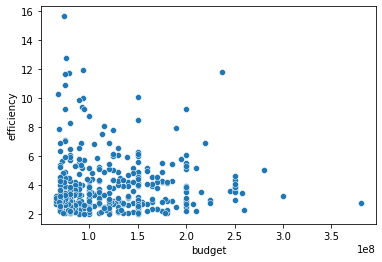

In [21]:
cleaned_efficiency = dropped_df[(dropped_df['efficiency'] < 100) & (dropped_df['efficiency'] > 2) & (dropped_df['budget'] > 65000000)]
sns.scatterplot(x='budget', y='efficiency', data=cleaned_efficiency)

In [22]:
cleaned_efficiency.describe()

,revenue,budget,popularity,vote_average,vote_count,earnings,efficiency
count,3.730000e+02,3.730000e+02,373.000000,373.000000,373.000000,373.000000,373.000000
mean,4.761751e+08,1.217533e+08,69.919571,6.483914,3054.249330,354.421776,3.927086
std,3.048873e+08,4.974214e+07,75.303393,0.707949,2357.092587,276.397225,2.003245
min,1.514937e+08,6.600000e+07,1.000000,4.700000,24.000000,77.930623,2.002247
25%,2.591758e+08,8.000000e+07,36.000000,6.000000,1288.000000,160.649836,2.652333
50%,3.735521e+08,1.100000e+08,54.000000,6.400000,2389.000000,256.372926,3.294630
75%,6.237228e+08,1.500000e+08,82.000000,7.000000,4321.000000,473.722818,4.502440
max,2.787965e+09,3.800000e+08,875.000000,8.200000,13752.000000,2550.965087,15.631499


Next analyze popularity and vote statistics

group by revenue then producers and count

In [23]:
cl_sorted = cleaned_efficiency.sort_values(by='revenue', ascending=False)
top_producers = cl_sorted.groupby(['name'])['revenue'].sum().sort_values(ascending=False).head(10)
top_producers


name
Peter Jackson        6402068099
James Cameron        5531881686
Michael Bay          5372581789
Christopher Nolan    3964368997
Steven Spielberg     3533970096
Sam Raimi            2988215066
Joss Whedon          2924961604
Francis Lawrence     2838300952
Gore Verbinski       2681671036
Carlos Saldanha      2532451792
Name: revenue, dtype: int64

In [24]:
cl_sorted.head(20)

,revenue,original_title,budget,popularity,release_date,vote_average,vote_count,name,earnings,efficiency
0,2787965087,Avatar,237000000,150,2009-12-10,7.2,11800,James Cameron,2550.965087,11.763566
25,1845034188,Titanic,200000000,100,1997-11-18,7.5,7562,James Cameron,1645.034188,9.225171
16,1519557910,The Avengers,220000000,144,2012-04-25,7.4,11776,Joss Whedon,1299.557910,6.907081
28,1513528810,Jurassic World,150000000,418,2015-06-09,6.5,8662,Colin Trevorrow,1363.528810,10.090192
44,1506249360,Furious 7,190000000,102,2015-04-01,7.3,4176,James Wan,1316.249360,7.927628
7,1405403694,Avengers: Age of Ultron,280000000,134,2015-04-22,7.3,6767,Joss Whedon,1125.403694,5.019299
124,1274219009,Frozen,150000000,165,2013-11-27,7.3,5295,Chris Buck,1124.219009,8.494793
31,1215439994,Iron Man 3,200000000,77,2013-04-18,6.8,8806,Shane Black,1015.439994,6.077200
546,1156730962,Minions,74000000,875,2015-06-17,6.4,4571,Kyle Balda,1082.730962,15.631499
26,1153304495,Captain America: Civil War,250000000,198,2016-04-27,7.1,7241,Anthony Russo,903.304495,4.613218


In [27]:
cl_sorted[cl_sorted['name'] == 'Sam Raimi']

,revenue,original_title,budget,popularity,release_date,vote_average,vote_count,name,earnings,efficiency
5,890871626,Spider-Man 3,258000000,115,2007-05-01,5.9,3576,Sam Raimi,632.871626,3.452991
159,821708551,Spider-Man,139000000,82,2002-05-01,6.8,5265,Sam Raimi,682.708551,5.911572
30,783766341,Spider-Man 2,200000000,35,2004-06-25,6.7,4321,Sam Raimi,583.766341,3.918832
37,491868548,Oz: The Great and Powerful,200000000,46,2013-03-07,5.7,3530,Sam Raimi,291.868548,2.459343


conclude

Clean and upload

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [ ]:
# Here you run your code to model the data


## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***